# DQN

## Dependencies

In [1]:
from pathlib import Path
import os

import ipdb

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import pandas as pd
import seaborn as sns
from imojify import imojify

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
from utils import Params, random_choice
from environment_tensor import WrappedEnvironment, Actions, CONTEXTS_LABELS, Cues

In [4]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

In [5]:
sns.set_theme(font_scale=1.5)
mpl.rcParams["font.family"] = ["sans-serif"]
mpl.rcParams["font.sans-serif"] = [
    "Fira Sans",
    "Computer Modern Sans Serif",
    "DejaVu Sans",
    "Verdana",
    "Arial",
    "Helvetica",
]
# plt.style.use("ggplot")

In [6]:
ROOT_PATH = Path("env").parent
PLOTS_PATH = ROOT_PATH / "plots"
print(f"Plots path: `{PLOTS_PATH.absolute()}`")

Plots path: `/home/kir0ul/Projects/RL_Olfaction/TriangleTask/plots`


In [7]:
def check_plots():
    if not PLOTS_PATH.exists():
        os.mkdir(PLOTS_PATH)

## Parameters

In [52]:
p = Params(
    seed=42,
    n_runs=1,
    total_episodes=1000,
    epsilon=0.2,
    alpha=0.05,
    gamma=0.9,
    nHiddenUnits=(5 * 5 + 2) * 2,
)
p

Params(seed=42, rng=None, n_runs=1, total_episodes=1000, epsilon=0.2, gamma=0.9, alpha=0.05, nLayers=5, nHiddenUnits=54, n_observations=None, n_actions=None)

In [9]:
# # Set the seed
# p.rng = np.random.default_rng(p.seed)

## The environment

In [10]:
# Load the environment
env = WrappedEnvironment(one_hot_state=True)

In [11]:
# Get number of actions
# n_actions = env.action_space.n
p.n_actions = env.numActions

# Get the number of state observations
# state, info = env.reset()
state = env.reset()
p.n_observations = len(state)

print(f"Number of actions: {p.n_actions}")
print(f"Number of observations: {p.n_observations}")

Number of actions: 4
Number of observations: 28


## Running the environment

In [12]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_units=16):
        super(DQN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_observations, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_actions),
        )

    def forward(self, x):
        return self.mlp(x)

In [13]:
if env.one_hot_state:
    net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=3 * p.n_observations,
    ).to(device)
else:
    net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=p.nHiddenUnits,
    ).to(device)
net

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=28, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=84, bias=True)
    (5): ReLU()
    (6): Linear(in_features=84, out_features=4, bias=True)
  )
)

In [14]:
# print("Model parameters:")
# print(list(net.parameters()))
print("\n\nParameters sizes summary:")
print([item.shape for item in net.parameters()])



Parameters sizes summary:
[torch.Size([84, 28]), torch.Size([84]), torch.Size([84, 84]), torch.Size([84]), torch.Size([84, 84]), torch.Size([84]), torch.Size([4, 84]), torch.Size([4])]


In [15]:
# summary(net, input_size=[state.shape], verbose=0)

In [16]:
optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.05
    maximize: False
    weight_decay: 0.01
)

In [17]:
class EpsilonGreedy:
    def __init__(
        self,
        epsilon,
        rng=None,
    ):
        self.epsilon = epsilon
        # if rng:
        #     self.rng = rng

    def choose_action(self, action_space, state, state_action_values):
        """Choose an action a in the current world state (s)"""

        def sample(action_space):
            return random_choice(action_space)

        # # First we randomize a number
        # if hasattr(self, "rng"):
        #     explor_exploit_tradeoff = self.rng.uniform(0, 1)
        # else:
        #     explor_exploit_tradeoff = np.random.uniform(0, 1)
        explor_exploit_tradeoff = torch.rand(1)

        # Exploration
        if explor_exploit_tradeoff.item() < self.epsilon:
            # action = action_space.sample()
            action = sample(action_space)

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `argmax()` would always take the first one)
            if torch.all(state_action_values == state_action_values[0]):
                action = sample(action_space)
            else:
                action = torch.argmax(state_action_values)
        return action

In [18]:
explorer = EpsilonGreedy(epsilon=p.epsilon, rng=p.rng)

### Main loop

In [19]:
rewards = torch.zeros((p.total_episodes, p.n_runs), device=device)
steps = torch.zeros((p.total_episodes, p.n_runs), device=device)
episodes = torch.arange(p.total_episodes, device=device)
all_states = []
all_actions = []
losses = [[] for _ in range(p.n_runs)]
episode_durations = []

for run in range(p.n_runs):  # Run several times to account for stochasticity
    # # Reset model
    # net = DQN(
    #     n_observations=p.n_observations, n_actions=p.n_actions, n_units=p.nHiddenUnits
    # ).to(device)
    # optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{p.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        state = state.clone().float().detach().to(device)
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            state_action_values = net(state).to(device)  # Q(s_t)
            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                state_action_values=state_action_values,
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action.item()).name)

            next_state, reward, done = env.step(
                action=action.item(), current_state=state
            )

            # See DQN paper for equations: https://arxiv.org/abs/1312.5602
            state_action_value = state_action_values[action].unsqueeze(-1)  # Q(s_t, a)
            if done:
                expected_state_action_value = reward
            else:
                with torch.no_grad():
                    next_state_values = (
                        net(next_state).to(device).max().unsqueeze(-1)
                    )  # Q(s_t+1, a)
                expected_state_action_value = (
                    reward + p.gamma * next_state_values
                )  # y_j (Bellman optimality equation)

            # Compute loss
            criterion = nn.MSELoss()
            loss = criterion(
                input=state_action_value, target=expected_state_action_value
            )  # TD update

            # # See DQN paper for equations: https://arxiv.org/abs/1312.5602
            # expected_state_action_values = torch.zeros_like(
            #     state_action_values, device=device
            # )
            # if done:
            #     expected_state_action_values[action] = reward
            # else:
            #     with torch.no_grad():
            #         next_state_value = (
            #             net(next_state).to(device).max()  # .unsqueeze(-1)
            #         )  # Q(s_t+1, a)
            #     expected_state_action_values[action] = (
            #         reward + p.gamma * next_state_value
            #     )  # y_j (Bellman optimality equation)

            # # Compute loss
            # criterion = nn.MSELoss()
            # loss = criterion(
            #     input=state_action_values, target=expected_state_action_values
            # )  # TD update

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()

            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(net.parameters(), 100)
            optimizer.step()

            # Move to the next state
            state = next_state

            total_rewards += reward
            step_count += 1
            losses[run].append(loss.item())

        episode_durations.append(step_count + 1)
        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count

In [20]:
# weights_metrics

In [21]:
# grads_metrics

In [22]:
# grads_metrics["avg_rolling"] = np.nan
# grads_metrics["std_rolling"] = np.nan
# for id in grads_metrics.id.unique():
#     grads_metrics.loc[grads_metrics[grads_metrics["id"] == id].index, "avg_rolling"] = (
#         grads_metrics.loc[grads_metrics[grads_metrics["id"] == id].index, "avg"]
#         .rolling(20)
#         .mean()
#     )
#     grads_metrics.loc[grads_metrics[grads_metrics["id"] == id].index, "std_rolling"] = (
#         grads_metrics.loc[grads_metrics[grads_metrics["id"] == id].index, "std"]
#         .rolling(20)
#         .mean()
#     )
# grads_metrics

## Visualization

In [23]:
# def plot_weights(weights_metrics):
#     """Plot the weights."""
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

#     sns.lineplot(x="steps_global", y="avg", hue="id", data=weights_metrics, ax=ax[0])
#     ax[0].set(ylabel="Weights (avg)")
#     ax[0].set(xlabel="Steps")

#     sns.lineplot(x="steps_global", y="std", hue="id", data=weights_metrics, ax=ax[1])
#     ax[1].set(ylabel="Weights (std)")
#     ax[1].set(xlabel="Steps")

#     fig.tight_layout()
#     plt.show()

In [24]:
# plot_weights(weights_metrics)

In [25]:
# def plot_gradients(grads_metrics):
#     """Plot the gradienta."""
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

#     sns.lineplot(
#         x="steps_global",
#         y="avg_rolling",
#         hue="id",
#         data=grads_metrics,
#         ax=ax[0],
#         palette=sns.color_palette()[0 : len(grads_metrics.id.unique())],
#     )
#     ax[0].set(ylabel="Gradients (avg)")
#     ax[0].set(xlabel="Steps")

#     sns.lineplot(
#         x="steps_global",
#         y="std_rolling",
#         hue="id",
#         data=grads_metrics,
#         ax=ax[1],
#         palette=sns.color_palette()[0 : len(grads_metrics.id.unique())],
#     )
#     ax[1].set(ylabel="Gradients (std)")
#     ax[1].set(xlabel="Steps")

#     fig.tight_layout()
#     plt.show()

In [26]:
# plot_gradients(grads_metrics)

In [27]:
def postprocess(episodes, p, rewards, steps):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": episodes.tile(p.n_runs).cpu(),
            "Rewards": rewards.T.flatten().cpu(),
            "Steps": steps.T.flatten().cpu(),
        }
    )
    # res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    return res

In [28]:
res = postprocess(episodes, p, rewards, steps)
res

,Episodes,Rewards,Steps
0,0,0.0,9.0
1,1,0.0,7.0
2,2,0.0,5.0
3,3,10.0,20.0
4,4,10.0,1.0
...,...,...,...
95,95,10.0,82.0
96,96,10.0,5.0
97,97,10.0,9.0
98,98,10.0,3.0


As a sanity check, we will plot the distributions of states and actions
with the following function:

In [29]:
def plot_states_actions_distribution(states, actions):
    """Plot the distributions of states and actions."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    # sns.histplot(data=states, ax=ax[0])
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(
        [item.value for item in Actions], labels=[item.name for item in Actions]
    )
    ax[1].set_title("Actions")
    fig.tight_layout()
    plt.show()

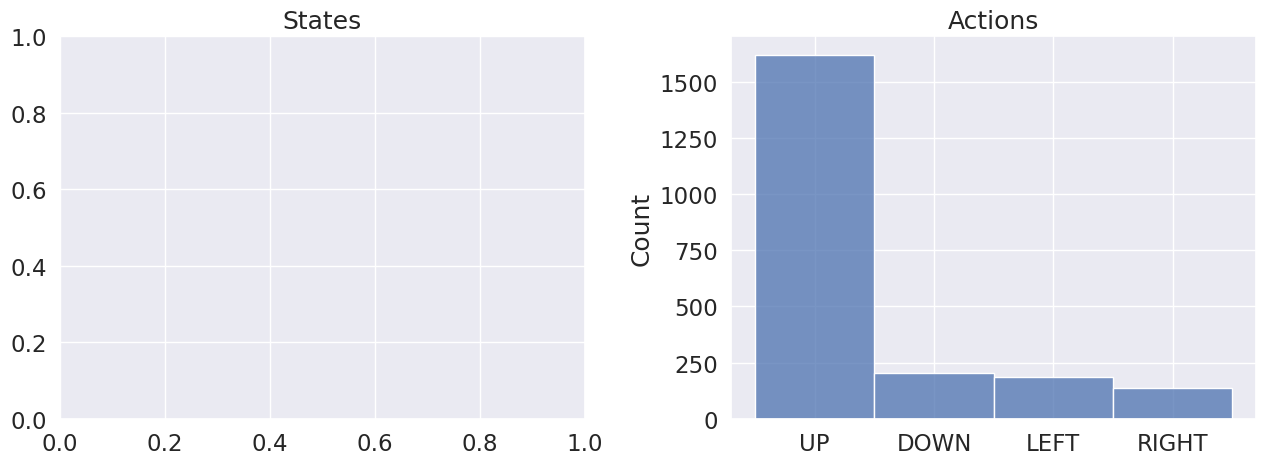

In [30]:
plot_states_actions_distribution(all_states, all_actions)

In [31]:
def plot_steps_and_rewards(df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data=df, x="Episodes", y="Rewards", ax=ax[0])
    ax[0].set(
        ylabel=f"Rewards\naveraged over {p.n_runs} runs" if p.n_runs > 1 else "Rewards"
    )

    sns.lineplot(data=df, x="Episodes", y="Steps", ax=ax[1])
    ax[1].set(
        ylabel=f"Steps number\naveraged over {p.n_runs} runs"
        if p.n_runs > 1
        else "Steps number"
    )

    fig.tight_layout()
    plt.show()

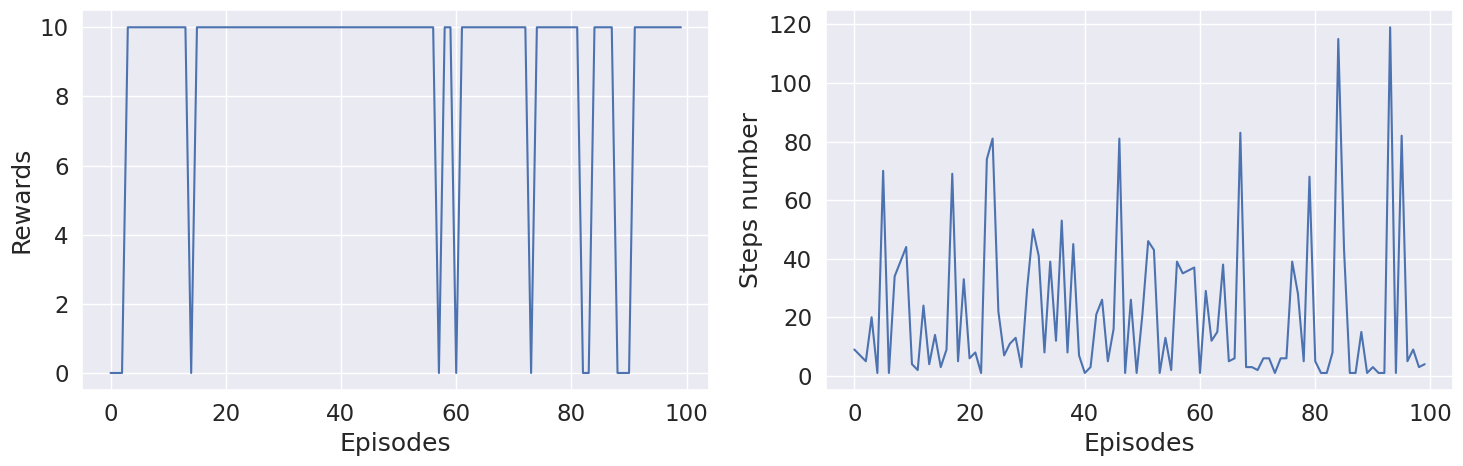

In [32]:
plot_steps_and_rewards(res)

In [33]:
window_size = 10
for idx, loss in enumerate(losses):
    current_loss = torch.tensor(loss, device=device)
    losses_rolling_avg = nn.functional.avg_pool1d(
        current_loss.view(1, 1, -1), kernel_size=window_size
    ).squeeze()
    tmp_df = pd.DataFrame(
        data={
            "Run": idx * torch.ones(len(losses_rolling_avg), device=device).int().cpu(),
            "Steps": torch.arange(0, len(losses_rolling_avg), device=device).cpu(),
            "Loss": losses_rolling_avg.cpu(),
        }
    )
    if idx == 0:
        loss_df = tmp_df
    else:
        loss_df = pd.concat((loss_df, tmp_df))
loss_df

,Run,Steps,Loss
0,0,0,0.367835
1,0,1,0.114491
2,0,2,0.015359
3,0,3,0.000427
4,0,4,19.401918
...,...,...,...
210,0,210,0.040702
211,0,211,0.034506
212,0,212,6.807045
213,0,213,6.612454


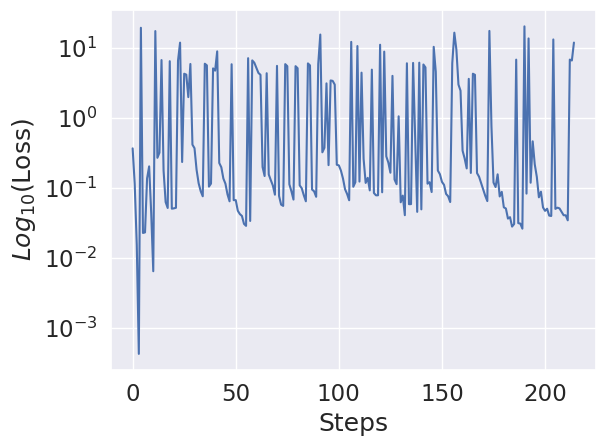

In [34]:
fig, ax = plt.subplots()
sns.lineplot(data=loss_df, x="Steps", y="Loss", ax=ax)
ax.set(
    ylabel=f"$Log_{{10}}(\\text{{Loss}})$\naveraged over {p.n_runs} runs"
    if p.n_runs > 1
    else "$Log_{10}(\\text{Loss})$"
)
ax.set(xlabel="Steps")
ax.set(yscale="log")
fig.tight_layout()
plt.show()

In [35]:
loss_df.iloc[-1].Loss

11.918519973754883

In [45]:
with torch.no_grad():
    q_values = torch.nan * torch.empty(
        (len(env.tiles_locations), len(Cues), p.n_actions), device=device
    )
    for tile_i, tile_v in enumerate(env.tiles_locations):
        for cue_i, cue_v in enumerate(Cues):
            state = torch.tensor([tile_v, cue_v.value], device=device).float()
            if env.one_hot_state:
                state = env.to_one_hot(state).float()
            q_values[tile_i, cue_i, :] = net(state).to(device)
q_values.shape

torch.Size([25, 3, 4])

In [46]:
def qtable_directions_map(qtable, rows, cols):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).values.reshape(rows, cols)
    qtable_best_action = qtable.argmax(axis=1).reshape(rows, cols)
    directions = {
        Actions.UP: "↑",
        Actions.DOWN: "↓",
        Actions.LEFT: "←",
        Actions.RIGHT: "→",
    }
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = torch.finfo(torch.float32).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[Actions(val.item())]
    qtable_directions = qtable_directions.reshape(rows, cols)
    return qtable_val_max, qtable_directions

In [47]:
def plot_policies(q_values, labels):
    """Plot the heatmap of the Q-values.

    Also plot the best action's direction with arrows."""

    fig, ax = plt.subplots(1, 3, figsize=(13, 4))
    for idx, cue in enumerate(labels):
        qtable_val_max, qtable_directions = qtable_directions_map(
            qtable=q_values[:, idx, :], rows=env.rows, cols=env.cols
        )
        sns.heatmap(
            qtable_val_max.cpu(),
            annot=qtable_directions,
            fmt="",
            ax=ax.flatten()[idx],
            cmap=sns.color_palette("Blues", as_cmap=True),
            linewidths=0.7,
            linecolor="black",
            xticklabels=[],
            yticklabels=[],
            annot_kws={"fontsize": "xx-large"},
            cbar_kws={"label": "Q-value"},
        ).set(title=labels[cue])
        for _, spine in ax.flatten()[idx].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.7)
            spine.set_color("black")

        # Annotate the ports names
        bbox = {
            "facecolor": "black",
            "edgecolor": "none",
            "boxstyle": "round",
            "alpha": 0.1,
        }
        ax.flatten()[idx].text(
            x=4.7,
            y=0.3,
            s="N",
            bbox=bbox,
            color="white",
        )
        ax.flatten()[idx].text(
            x=0.05,
            y=4.9,
            s="S",
            bbox=bbox,
            color="white",
        )
        ax.flatten()[idx].text(
            x=4.7,
            y=4.9,
            s="E",
            bbox=bbox,
            color="white",
        )
        ax.flatten()[idx].text(
            x=0.05,
            y=0.3,
            s="W",
            bbox=bbox,
            color="white",
        )

    # Make background transparent
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    fig.tight_layout()
    plt.show()

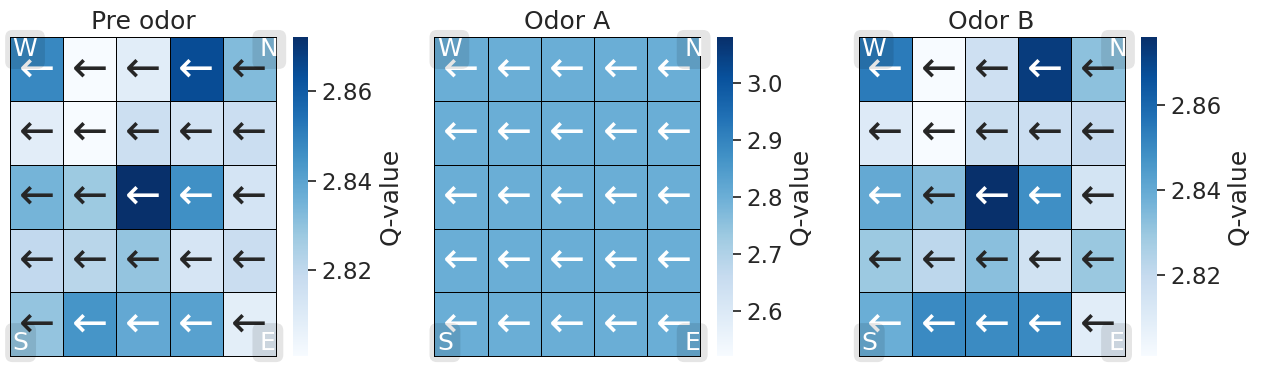

In [48]:
plot_policies(q_values=q_values, labels=CONTEXTS_LABELS)

In [49]:
env.tiles_locations.reshape((env.rows, env.cols))

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])

In [50]:
[item for item in Actions]

[<Actions.UP: 0>, <Actions.DOWN: 1>, <Actions.LEFT: 2>, <Actions.RIGHT: 3>]

In [51]:
[item for item in Cues]

[<Cues.NoOdor: 0>, <Cues.OdorA: 1>, <Cues.OdorB: 2>]

In [43]:
net(torch.tensor([4, 1]).float())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 28x84)

In [ ]:
net(torch.tensor([19, 1]).float()).argmax()